# FWI Bias Calculation Example

This notebook demonstrates the computation of **Fire Weather Index (FWI)** biases for CMIP6–CORDEX simulations evaluated against ERA5-Land FWI data. For clarity and computational efficiency, the analysis is restricted to a **three-year period (2018–2020)** and the **JJAS season**, using a single model realization as an example.

The notebook workflow is fully automated and can be readily adapted to assess different model runs, time periods, or seasons by modifying the configuration file.

## Table of Contents

* [Configuration via YAML File](#configuration-via-yaml-file)
* [Extraction of Configuration Parameters](#extraction-of-configuration-parameters)
* [ERA5-Land FWI: Loading and Visualization](#era5-land-fwi-loading-and-visualization)
* [Model Selection and Visualization](#model-selection-and-visualization)
* [Bias Computation with Respect to ERA5-Land](#bias-computation-with-respect-to-era5-land)
* [Session Information](#session-information)

First, we load the required variables to run the notebook:

In [2]:
options(java.parameters = "-Xmx64g")

library(loadeR)
library(transformeR)
library(fireDanger)
library(visualizeR)
library(magrittr)
library(grid)
library(gridExtra)
library(yaml)
library(RColorBrewer)

Loading required package: rJava

Loading required package: loadeR.java

Java version 11x amd64 by Azul Systems, Inc. detected

NetCDF Java Library v4.6.0-SNAPSHOT (23 Apr 2015) loaded and ready

Loading required package: climate4R.UDG

climate4R.UDG version 0.2.6 (2023-06-26) is loaded

Please use 'citation("climate4R.UDG")' to cite this package.

loadeR version 1.8.1 (2023-06-22) is loaded


Get the latest stable version (1.8.2) using <devtools::install_github(c('SantanderMetGroup/climate4R.UDG','SantanderMetGroup/loadeR'))>

Please use 'citation("loadeR")' to cite this package.




    _______   ____  ___________________  __  ________ 
   / ___/ /  / /  |/  / __  /_  __/ __/ / / / / __  / 
  / /  / /  / / /|_/ / /_/ / / / / __/ / /_/ / /_/_/  
 / /__/ /__/ / /  / / __  / / / / /__ /___  / / \ \ 
 \___/____/_/_/  /_/_/ /_/ /_/  \___/    /_/\/   \_\ 
 
      github.com/SantanderMetGroup/climate4R



transformeR version 2.2.2 (2023-10-26) is loaded


Get the latest stable version (2.2.3) using <devtools::install_github('SantanderMetGroup/transformeR')>

Please see 'citation("transformeR")' to cite this package.

fireDanger version 1.2.0 (2025-04-15) is loaded

Type <vignette("Climate_Services_2017", package = "fireDanger")> for package overview and examples
Please use citation("fireDanger") to cite this package.

visualizeR version 1.6.4 (2023-10-26) is loaded

Please see 'citation("visualizeR")' to cite this package.



## Configuration via YAML File <a class="anchor" id="configuration-via-yaml-file"></a> 

A YAML configuration file is used to define the key parameters of the analysis, including the simulation models, the target season, and the evaluation years. This approach ensures reproducibility and facilitates batch processing across multiple configurations.

After loading the `YAML` file, we inspect the available models as well as the selected temporal settings (season and years).

In [3]:
suppressWarnings(
    yaml.file <- yaml.load_file("/mnt/CORDEX_CMIP6_tmp/user_tmp/omirones/yaml/workflow.yaml")
)

In [4]:
print(yaml.file)

$models
$models$`ALARO1-SFX`
[1] "/mnt/CORDEX_CMIP6_tmp/user_tmp/jbediajimenez/data_catalogs//ALARO1-SFX_fwi.ncml"

$models$`CCLM6-0-1-URB`
[1] "/mnt/CORDEX_CMIP6_tmp/user_tmp/jbediajimenez/data_catalogs//CCLM6-0-1-URB_fwi.ncml"

$models$`CNRM-ALADIN64E1`
[1] "/mnt/CORDEX_CMIP6_tmp/user_tmp/jbediajimenez/data_catalogs//CNRM-ALADIN64E1_fwi.ncml"

$models$`ICON-CLM-202407-1-1`
[1] "/mnt/CORDEX_CMIP6_tmp/user_tmp/jbediajimenez/data_catalogs//ICON-CLM-202407-1-1_fwi.ncml"

$models$`REMO2020-2-2-iMOVE`
[1] "/mnt/CORDEX_CMIP6_tmp/user_tmp/jbediajimenez/data_catalogs//REMO2020-2-2-iMOVE_fwi.ncml"

$models$`REMO2020-2-2-iMOVE-LUC`
[1] "/mnt/CORDEX_CMIP6_tmp/user_tmp/jbediajimenez/data_catalogs//REMO2020-2-2-iMOVE-LUC_fwi.ncml"

$models$`ROAM-NBS`
[1] "/mnt/CORDEX_CMIP6_tmp/user_tmp/jbediajimenez/data_catalogs//ROAM-NBS_fwi.ncml"


$season
[1] "6:9"

$years
[1] "2018:2020"



## Extraction of Configuration Parameters <a class="anchor" id="extraction-of-configuration-parameters"></a>

Once the `YAML` file is loaded, the relevant entries are stored in R objects for use throughout the notebook. In particular, we extract:

- The list of available CMIP6–CORDEX models

- The target season (defined as a range of months)

- The evaluation years

- These parameters control all subsequent data loading and processing steps.

In [5]:
lf <- yaml.file$models
models <- names(lf)

print(models)

[1] "ALARO1-SFX"             "CCLM6-0-1-URB"          "CNRM-ALADIN64E1"       
[4] "ICON-CLM-202407-1-1"    "REMO2020-2-2-iMOVE"     "REMO2020-2-2-iMOVE-LUC"
[7] "ROAM-NBS"              


In [6]:
season <- eval(parse(text = yaml.file$season))

month.names <- c("Jan","Feb","Mar","Apr","May","Jun","Jul", 
                 "Aug", "Sep","Oct","Nov","Dec")

year <- eval(parse(text = yaml.file$years))

In [7]:
year

[1] 2018 2019 2020

## ERA5-Land FWI: Loading and Visualization <a class="anchor" id="era5-land-fwi-loading-and-visualization"></a>

In this step, ERA5-Land FWI data are loaded using the `loadGridData` function from the loadeR package. The spatial climatology for the selected season and period is then computed and visualized using `spatialPlot` from the `visualizeR` package.

A color palette commonly used for FWI visualization is defined in advance to ensure consistency across plots.

[2025-12-22 09:00:43.74496] Defining geo-location parameters

[2025-12-22 09:00:43.793038] Defining time selection parameters

[2025-12-22 09:00:43.946234] Retrieving data subset ...

[2025-12-22 09:00:58.965112] Done

[2025-12-22 09:00:59.862076] - Computing climatology...

[2025-12-22 09:01:03.089457] - Done.



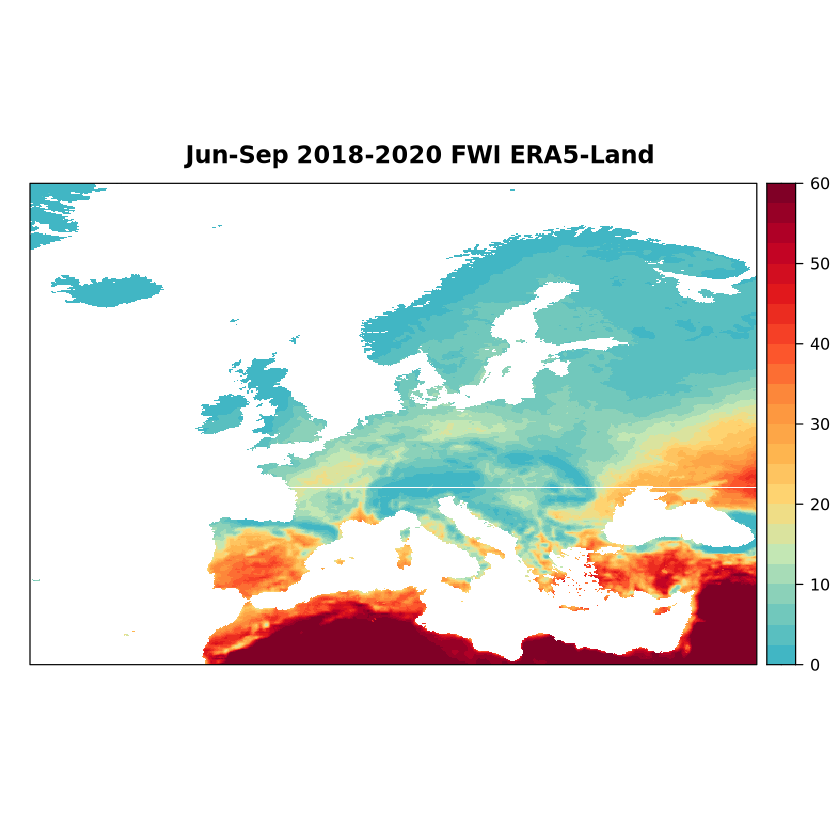

In [8]:
fwi.colors <- colorRampPalette(c(rev(brewer.pal(9, "YlGnBu")[3:5]), 
                                 brewer.pal(9, "YlOrRd")[3:9]))
     

fwi_era5 <- loadGridData("/mnt/CORDEX_CMIP6_tmp/user_tmp/jbediajimenez/data_catalogs/fwi_era5-land.ncml", 
                         var = "FWI", years = year, season = season)

sp.era5 <- spatialPlot(climatology(fwi_era5),
                        at = seq(0,60,2.5),
                        set.min = 0, set.max = 60,
                        col.regions = fwi.colors,
                        main = paste0(month.names[season[1]],"-",month.names[season[length(season)]]," ", 
                                         year[1],"-",year[length(year)],
                                         " FWI ERA5-Land"),
cex.main = 0.75)

sp.era5

## Model Selection and Visualization <a class="anchor" id="model-selection-and-visualization"></a>

For illustration purposes, we select a single model from the list defined in the `YAML` file. In this example, the model **REMO2020-2-2-iMOVE-LUC** (the sixth entry in the configuration) is used.

The selected model FWI data are loaded following the same procedure applied to ERA5-Land. A seasonal climatology is then computed and visualized, enabling a direct qualitative comparison with the reference dataset.

In [9]:
i <- 6
(model <- models[i])
print(lf[i][[1]])

[1] "REMO2020-2-2-iMOVE-LUC"

[1] "/mnt/CORDEX_CMIP6_tmp/user_tmp/jbediajimenez/data_catalogs//REMO2020-2-2-iMOVE-LUC_fwi.ncml"


[2025-12-22 09:01:05.601637] Defining geo-location parameters

[2025-12-22 09:01:06.048112] Defining time selection parameters

[2025-12-22 09:01:06.10987] Retrieving data subset ...

[2025-12-22 09:01:15.209764] Done

[2025-12-22 09:01:15.586672] - Computing climatology...

[2025-12-22 09:01:17.554644] - Done.



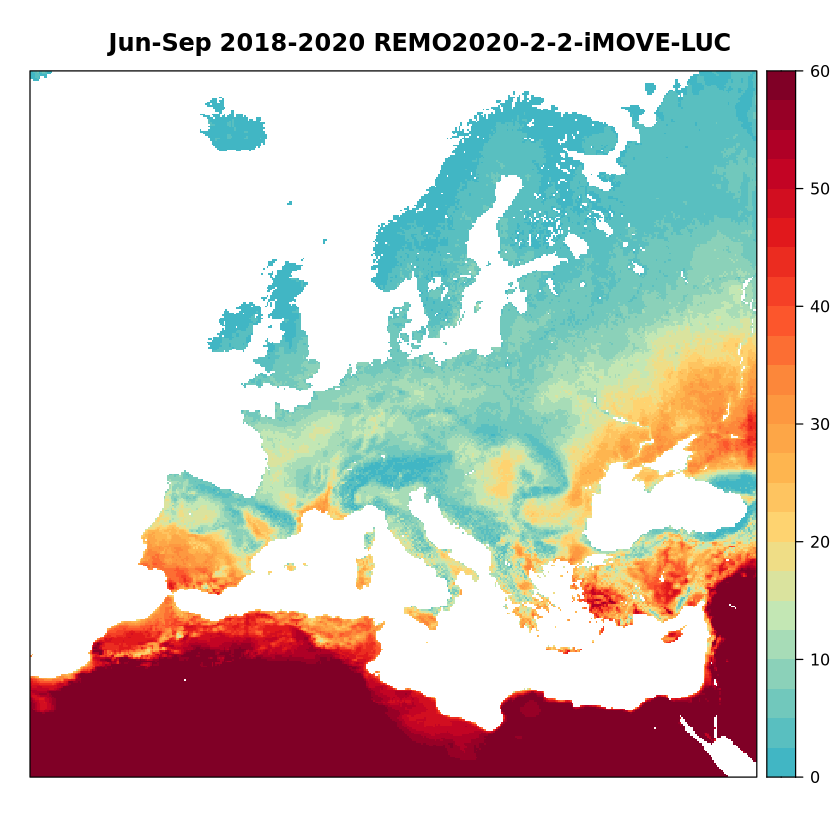

In [10]:
fwi_gcm <- loadGridData(lf[i][[1]], 
                        var = "FWI", years = year, season = season) 

sp.gcm <- spatialPlot(climatology(fwi_gcm),
                        at = seq(0,60,2.5),
                        set.min = 0, set.max = 60, 
                        col.regions = fwi.colors,
                        main = paste0(month.names[season[1]],"-",month.names[season[length(season)]]," ", 
                                         year[1],"-",year[length(year)]," ",model), 
                        cex.main = 0.75)

sp.gcm

## Bias Computation with Respect to ERA5-Land <a class="anchor" id="bias-computation-with-respect-to-era5-land"></a>

Model biases are computed relative to ERA5-Land FWI using the `gridArithmetics` function from the `transformeR` package. Since arithmetic operations require datasets with identical spatial grids, the model output is first interpolated onto the ERA5-Land grid.

The bias is defined as the difference between the interpolated model climatology and the ERA5-Land climatology. The resulting bias field is visualized using `spatialPlot` with a diverging color palette, highlighting regions with negative and positive deviations.

Warning message in interpGrid(fwi_gcm, new.coordinates = getGrid(fwi_era5)):
“The new latitudes are outside the data extent”
[2025-12-22 09:01:31.24811] Calculating nearest neighbors...

[2025-12-22 09:13:34.957603] Performing nearest interpolation... may take a while

[2025-12-22 09:13:41.983576] Done

[2025-12-22 09:14:18.817303] - Computing climatology...

[2025-12-22 09:14:22.624723] - Done.



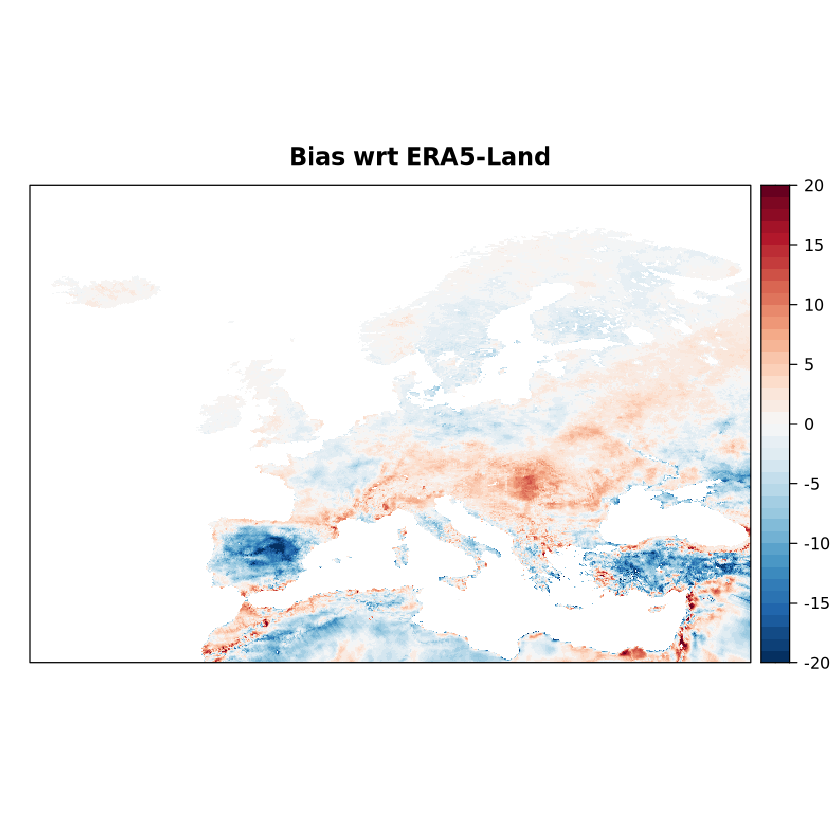

In [11]:
bias <- gridArithmetics(interpGrid(fwi_gcm,
                                   new.coordinates = getGrid(fwi_era5)),
                                   fwi_era5,
                                   operator = "-")

sp.bias <- spatialPlot(climatology(bias), rev.colors = TRUE, 
                       color.theme = "RdBu", at = seq(-20,20,1), set.min = -20, set.max = 20, main = "Bias wrt ERA5-Land",
                       cex.main = 0.975)


sp.bias

## Session Information <a class="anchor" id="session-information"></a>

For reproducibility, the notebook concludes by reporting the full R session information, including package versions and system details used to generate the results.

In [33]:
print(sessionInfo())

R version 4.3.3 (2024-02-29)
Platform: x86_64-conda-linux-gnu (64-bit)
Running under: Ubuntu 24.04.3 LTS

Matrix products: default
BLAS/LAPACK: /mnt/CORDEX_CMIP6_tmp/user_tmp/omirones/conda_envs/deep-fwi/lib/libopenblasp-r0.3.30.so;  LAPACK version 3.12.0

locale:
 [1] LC_CTYPE=C.UTF-8          LC_NUMERIC=C             
 [3] LC_TIME=C.UTF-8           LC_COLLATE=C.UTF-8       
 [5] LC_MONETARY=C.UTF-8       LC_MESSAGES=C.UTF-8      
 [7] LC_PAPER=C.UTF-8          LC_NAME=C.UTF-8          
 [9] LC_ADDRESS=C.UTF-8        LC_TELEPHONE=C.UTF-8     
[11] LC_MEASUREMENT=C.UTF-8    LC_IDENTIFICATION=C.UTF-8

time zone: Etc/UTC
tzcode source: system (glibc)

attached base packages:
[1] grid      stats     graphics  grDevices utils     datasets  methods  
[8] base     

other attached packages:
 [1] yaml_2.3.10         gridExtra_2.3       magrittr_2.0.4     
 [4] visualizeR_1.6.4    fireDanger_1.2.0    convertR_0.3.0     
 [7] udunits2_0.13.2.2   transformeR_2.2.2   loadeR.2nc_0.1.3   
[10] load